<h1><b><span style="color: #e56b6f; font-size: 28px">IMPORTING LIBRARIES</span></b></h1>


In [1]:
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
import re
from wordcloud import WordCloud

# Preprocessing and evaluation
import nltk
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l1, l2

pd.set_option('display.max_colwidth', 500)


<h1><b><span style="color: #e56b6f; font-size: 28px">DATA LOADING</span></b></h1>


In [2]:
df = pd.read_excel('BBN2021.xlsx', sheet_name='Tweets')
df.head()

,User,Username,UTC Date,Tweet,Binders,Permalink,Retweet count,Likes count,Tweet value
0,The Whistler Newspaper,@TheWhistlerNG,2021-09-27 12:15:09,"This is coming after Pere and Angel who were asked to leave the house during the Sunday live eviction show, were moved to a white room.\n\n#BBNaija6 #BBNaija pere\n#thewhistlerng #Biggie https://t.co/cUT67ite7M",NaN,https://www.twitter.com/user/status/1442462817223909380,0,3,24.42
1,Mufunwa ⚓️ 🌞,@MufunwaV,2021-09-27 12:14:45,Not gonna lie big brother messed up with what they did to Pere isn't fair and I am not even a fan #Bbnaija6 #BBNaijaShineYaEye #Bbnaija,NaN,https://www.twitter.com/user/status/1442462715079892996,0,3,0.82
2,Father figure 🇿🇦💟,@nathynice,2021-09-27 12:14:23,"Production team doesn't care a bit about these peoples mental health ,it's sad 😭😭 I can't begin to imagine what's going on on their heads right now, Pere who's been in military and Angel who already battles with anxiety #BBNaija #JusticeForPere #BBNaijaShineYaEye https://t.co/sUQsQdleDx",NaN,https://www.twitter.com/user/status/1442462621425307661,1,8,1.55
3,CARL (MIKASHITA) 🔰,@Backupforcarl,2021-09-27 12:13:31,Kayode is the one responsible for this show being boring not the HMs \n\n#BBNaija \n#BBNaijaShineYaEye,NaN,https://www.twitter.com/user/status/1442462404240084999,0,5,0.91
4,The Whistler Newspaper,@TheWhistlerNG,2021-09-27 12:12:52,VIDEO: Pere's fans protest BBNaija’s eviction twist in Lagos\n\n#BBNaija6 #BBNaija pere\n#thewhistlerng #Biggie https://t.co/DnGld8IEw1,NaN,https://www.twitter.com/user/status/1442462240351965193,0,2,101.75


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   User           10000 non-null  object        
 1   Username       10000 non-null  object        
 2   UTC Date       10000 non-null  datetime64[ns]
 3   Tweet          10000 non-null  object        
 4   Binders        0 non-null      float64       
 5   Permalink      10000 non-null  object        
 6   Retweet count  10000 non-null  int64         
 7   Likes count    10000 non-null  int64         
 8   Tweet value    10000 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 703.2+ KB


<h1><b><span style="color: #e56b6f; font-size: 28px">TEXT PROCESSING</span></b></h1>


In [5]:
def processTweet(tweet):

    '''
    Input:
        tweet: a string containing a tweet
    Output:
        tweets_clean: cleaned tweet
    '''

    #removing \n
    tweet = re.sub(r'\n+','',tweet)

    #removing non-english characters with/without hashtags
    tweet = re.sub(r'#?\s?[^\u0000-\u05C0\u2100-\u214F]+', '', tweet)

    #removing hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*','', tweet)

    #removing numbers
    tweet = re.sub(r'[0-9]','', tweet)

    #removing hashtags
    tweet = re.sub(r'#[A-Za-z0-9]+','', tweet)

    return tweet

In [6]:
df['Cleaned Tweet'] = df['Tweet'].apply(processTweet)
df[['Tweet', 'Cleaned Tweet']].iloc[500:510]

,Tweet,Cleaned Tweet
500,"Some persons have been paid by the organizers to justify their act last night. \nJust keep up with comments, you will see some set of person doing just that.\nThis is why we are were we are in this country, we can never stand for the truth ever.#BBNaija #BBNaijaSeason6 #BBNajia6","Some persons have been paid by the organizers to justify their act last night. Just keep up with comments, you will see some set of person doing just that.This is why we are were we are in this country, we can never stand for the truth ever."
501,Feel the drill with good music this morning. \n\n#BBNaija #sundayvibes #BBNaija6\n#Yargi #Binance #LALISA #btw21 #BBNaijaShineYaEye #JoshuaUsyk #aespa #KingKohli #LALISALOVEBLINKS #AFLGF #الهند_تقتل_المسلمين #انقذوا_عزوز_من_اهله #별처럼빛날은비와우리사이\nhttps://t.co/C4AuJTx5hL,Feel the drill with good music this morning. __ ___
502,"@VictorEdim8 I call it ""Healthy competition"" by whitemoney look at it this way, he didn't step on anybody's toes to be loved, now thats healthy, #BBNaija #BBNaija6","@VictorEdim I call it ""Healthy competition"" by whitemoney look at it this way, he didn't step on anybody's toes to be loved, now thats healthy,"
503,"#Deficonnect to be listed on @Hotbit by 29 September, 25% burned already and more to burn. Defipay on the way + more program to benefit. Buy now https://t.co/FTVjiNW6Xo\n\nhttps://t.co/vWqRHvMZ94\n\n#Binance #Bitcoin #NFTs #NFTdrop #Nigeria #BBNaija #BBNaijaShineYaEye #BBNaija6 https://t.co/8fUz8K0BGS","to be listed on @Hotbit by September, % burned already and more to burn. Defipay on the way + more program to benefit. Buy now"
504,@BBNaija @Ebuka there is nthn good about this morning at all. What's d update? What's d way foward? Are u taking us for granted? We voted and our votes didn't count. Are we a joke to u guys? Is PERE your PLAYTOY? why are u stressing us?? #justiceforpere #BBNaija #BBNaija6,@BBNaija @Ebuka there is nthn good about this morning at all. What's d update? What's d way foward? Are u taking us for granted? We voted and our votes didn't count. Are we a joke to u guys? Is PERE your PLAYTOY? why are u stressing us??
505,READY TO PUMP IN MORE VOTES VORACIOUSLY 🔫🔫\n\n#whitemoney #BBNaija #BBNaijaSeason6 #BBNaijaShineYaEye https://t.co/EBDcLezJ2e,READY TO PUMP IN MORE VOTES VORACIOUSLY
506,#BBNaija #WMG #BBNaija6 #BBNaijaSeason6 #BBNajia6 #VoteOnlyWhitemoney #VoteforWhitemoney https://t.co/q89AO7cYjM,
507,Pere's fans ain't smiling at all.. They all come out for Biggie...😂 #BBNaija #BBNaijia6 #Bbnaijia #BBNaijaShineYaEye #BBNaija6 #bbnaija2021 https://t.co/67b6V38vSi,Pere's fans ain't smiling at all.. They all come out for Biggie...
508,"On this day last year, @Thedorathybach @nengiofficial @NeoAkpofure @veeiye were respectively the runners up of the BBN S5 reality show. Graphics by me.\n#YOUNGANDRECKLESS #SHOWmusicvideo #BBNaija #BBNaijia6 #BBNajia #BBN #BBNaijaShineYaEye #IALbyLaycon https://t.co/DZRdyiCHxr","On this day last year, @Thedorathybach @nengiofficial @NeoAkpofure @veeiye were respectively the runners up of the BBN S reality show. Graphics by me."
509,"@ManLikeIcey Na wa o! Pere cannot go and Angel cannot win..The whole thing have been arranged..Anyways to calm you guyz down,Pere was briefed on what to do..everything in there,is scripted but Angel is not aware..Told you guyz before now those the game choose.#BBNaija #BBNaijaShineYaEye","@ManLikeIcey Na wa o! Pere cannot go and Angel cannot win..The whole thing have been arranged..Anyways to calm you guyz down,Pere was briefed on what to do..everything in there,is scripted but Angel is not aware..Told you guyz before now those the game choose."


In [10]:
df['Cleaned Tweet'][506]

'       '

<h1><b><span style="color: #e56b6f; font-size: 18px">Stemming Vs. lemmatization</span></b></h1>


In [11]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [12]:
print('Original:')
print(df['Cleaned Tweet'][549])
print()

sentence = []
for word in df['Cleaned Tweet'][549].split():
    stemmer = SnowballStemmer('english')
    sentence.append(stemmer.stem(word))
print('Stemming:')
print(' '.join(sentence))
print()

sentence = []
for word in df['Cleaned Tweet'][549].split():
    lemmatizer = WordNetLemmatizer()
    sentence.append(lemmatizer.lemmatize(word, 'v'))
print('Lemmatization:')
print(' '.join(sentence))

Original:
It's not even  hours yet, and I'm already missing Saga and NiniWho would be helping us record them every day?              

Stemming:
it not even hour yet, and i'm alreadi miss saga and niniwho would be help us record them everi day?

Lemmatization:
It's not even hours yet, and I'm already miss Saga and NiniWho would be help us record them every day?


In [13]:
def cleanTweet(text):
    #remove punctuations and uppercase
    clean_text = text.translate(str.maketrans('','',string.punctuation)).lower()

    #remove stopwords
    clean_text = [word for word in clean_text.split() if word not in stopwords.words('english')]

    #lemmatize the word
    sentence = []
    for word in clean_text:
        lemmatizer = WordNetLemmatizer()
        sentence.append(lemmatizer.lemmatize(word, 'v'))

    return ' '.join(sentence)

In [14]:
df['Cleaned Tweet'] = df['Cleaned Tweet'].apply(cleanTweet)

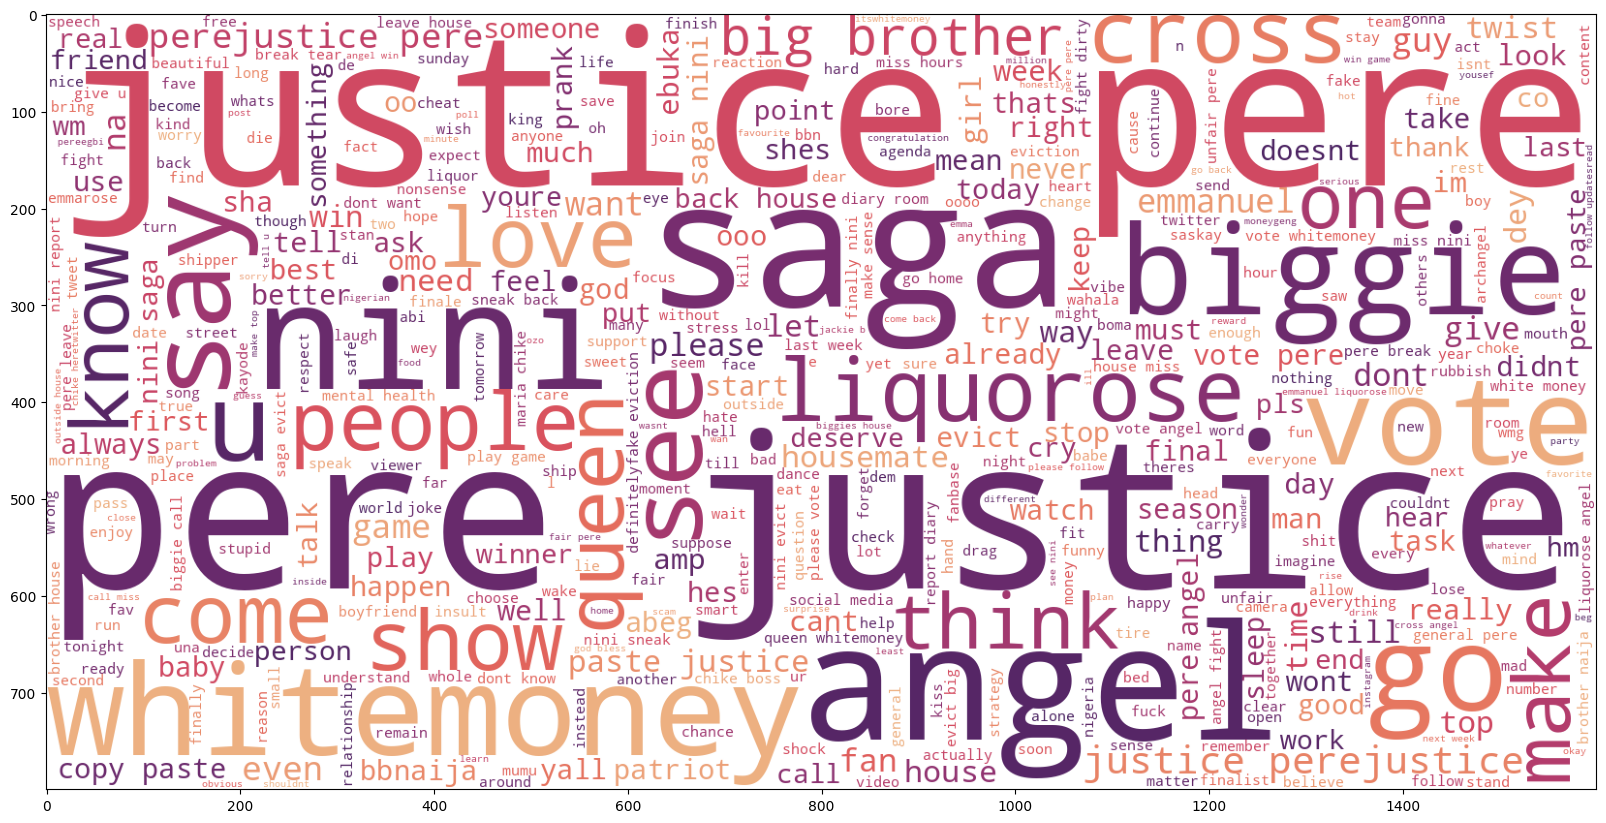

In [15]:
# After cleaning, let's see the most common used word
plt.figure(figsize=(20,20))
wc = WordCloud(max_words=1000, min_font_size=10,
                height=800,width=1600,background_color="white",
                colormap='flare').generate(' '.join(df['Cleaned Tweet']))

plt.imshow(wc)

<h1><b><span style="color: #e56b6f; font-size: 18px">FIND POLARITY AND SENTIMENT</span></b></h1>


In [16]:
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
# def SIA(tweet):
#     sia = SentimentIntensityAnalyzer()

#     score = sia.polarity_scores(tweet)

#     return score['compound']

# df['polarity_sia'] = df['Cleaned Tweet'].apply(SIA)

# df[['Cleaned Tweet', 'polarity_sia']].iloc[500:510]

In [17]:

def getPolarity(tweet):
    return TextBlob(tweet).sentiment.polarity

df['Polarity'] = df['Cleaned Tweet'].apply(getPolarity)

df[['Cleaned Tweet', 'Polarity']].iloc[500:510]

,Cleaned Tweet,Polarity
500,persons pay organizers justify act last night keep comment see set person thatthis country never stand truth ever,0.000
501,feel drill good music morning,0.700
502,victoredim call healthy competition whitemoney look way didnt step anybodys toe love thats healthy,0.500
503,list hotbit september burn already burn defipay way program benefit buy,0.000
504,bbnaija ebuka nthn good morning whats update whats way foward u take us grant vote vote didnt count joke u guy pere playtoy u stress us,0.700
505,ready pump vote voraciously,0.200
506,,0.000
507,peres fan aint smile come biggie,0.300
508,day last year thedorathybach nengiofficial neoakpofure veeiye respectively runners bbn reality show graphics,0.000
509,manlikeicey na wa pere cannot go angel cannot winthe whole thing arrangedanyways calm guyz downpere brief doeverything thereis script angel awaretold guyz game choose,0.025


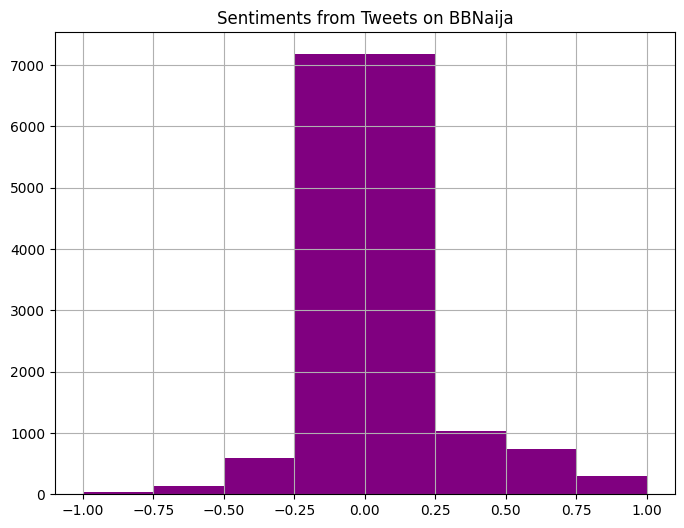

In [18]:
fig, ax = plt.subplots(figsize=(8, 6))

# Plot histogram of the polarity values
df['Polarity'].hist(bins=[-1, -0.75, -0.5, -0.25, 0.25, 0.5, 0.75, 1],
             ax=ax,
             color="purple")

plt.title("Sentiments from Tweets on BBNaija")
plt.show()

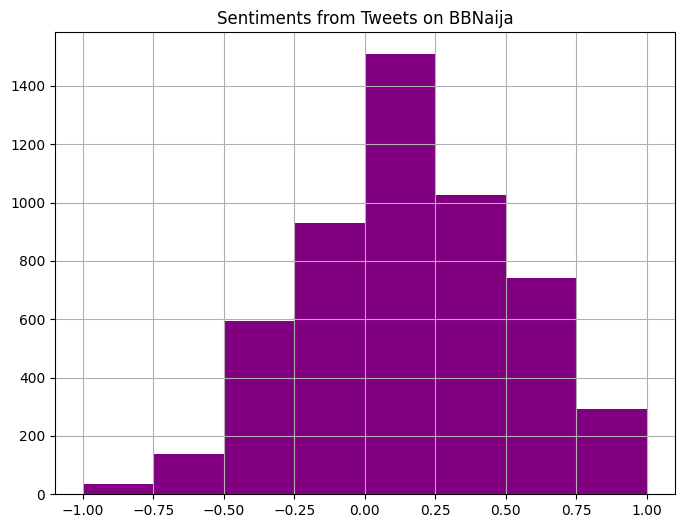

In [19]:
# Remove polarity values equal to zero for better visualization
sentiment_df = df[df.Polarity != 0]
fig, ax = plt.subplots(figsize=(8, 6))

# Plot histogram with break at zero
sentiment_df['Polarity'].hist(bins=[-1, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1],
             ax=ax,
             color="purple")

plt.title("Sentiments from Tweets on BBNaija")
plt.show()

Seems tweets are more neutral

In [20]:
def getSentiment(polarity):

    if polarity > 0:
        sentiment = 'Positive'

    elif polarity == 0:
        sentiment = 'Neutral'

    else:
        sentiment = 'Negative'

    return sentiment

df['Sentiment'] = df['Polarity'].apply(getSentiment)

df[['Cleaned Tweet', 'Polarity', 'Sentiment']].iloc[500:510]

,Cleaned Tweet,Polarity,Sentiment
500,persons pay organizers justify act last night keep comment see set person thatthis country never stand truth ever,0.000,Neutral
501,feel drill good music morning,0.700,Positive
502,victoredim call healthy competition whitemoney look way didnt step anybodys toe love thats healthy,0.500,Positive
503,list hotbit september burn already burn defipay way program benefit buy,0.000,Neutral
504,bbnaija ebuka nthn good morning whats update whats way foward u take us grant vote vote didnt count joke u guy pere playtoy u stress us,0.700,Positive
505,ready pump vote voraciously,0.200,Positive
506,,0.000,Neutral
507,peres fan aint smile come biggie,0.300,Positive
508,day last year thedorathybach nengiofficial neoakpofure veeiye respectively runners bbn reality show graphics,0.000,Neutral
509,manlikeicey na wa pere cannot go angel cannot winthe whole thing arrangedanyways calm guyz downpere brief doeverything thereis script angel awaretold guyz game choose,0.025,Positive


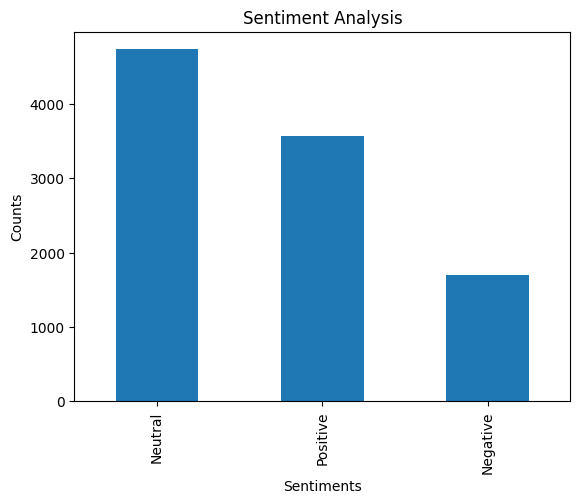

In [21]:
## plot visualization of count
plt.title('Sentiment Analysis')
plt.xlabel('Sentiments')
plt.ylabel('Counts')
df['Sentiment'].value_counts().plot(kind='bar')
plt.show()

In [22]:
# Filter the DataFrame for positive sentiment
pos_df = df[df.Sentiment == 'Positive']

# Filter the DataFrame for negative sentiment
neg_df = df[df.Sentiment == 'Negative']

# Filter the DataFrame for neutral sentiment
neu_df = df[df.Sentiment == 'Neutral']

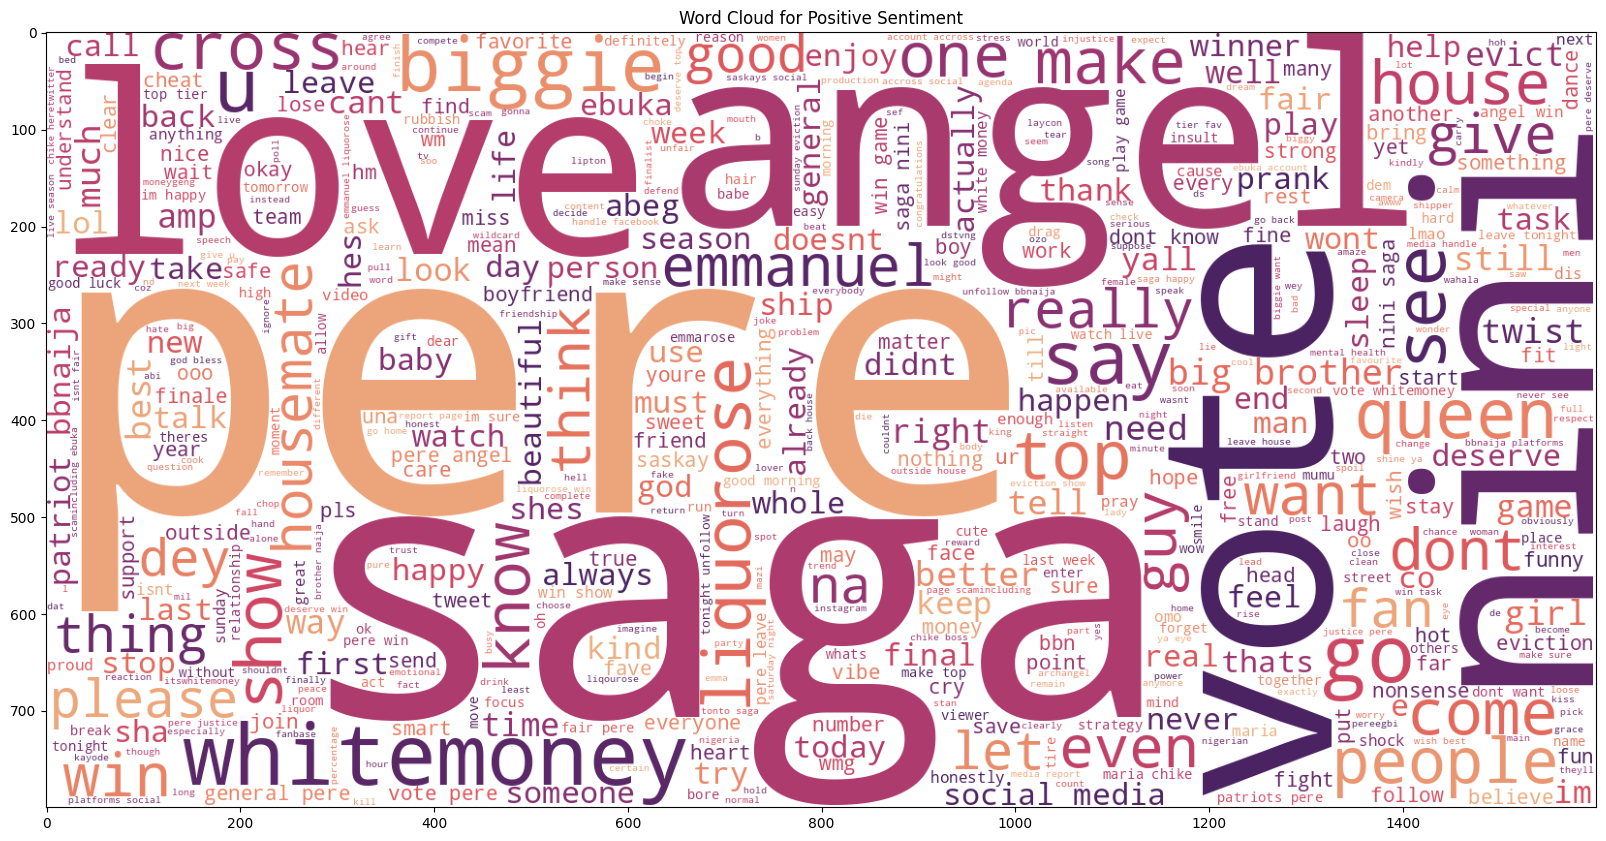

In [23]:
plt.figure(figsize=(20,20))
plt.title('Word Cloud for Positive Sentiment')
pos_wc = WordCloud(max_words=1000, min_font_size=10,
                height=800,width=1600,background_color="white",
                colormap='flare').generate(' '.join(pos_df['Cleaned Tweet']))

plt.imshow(pos_wc)

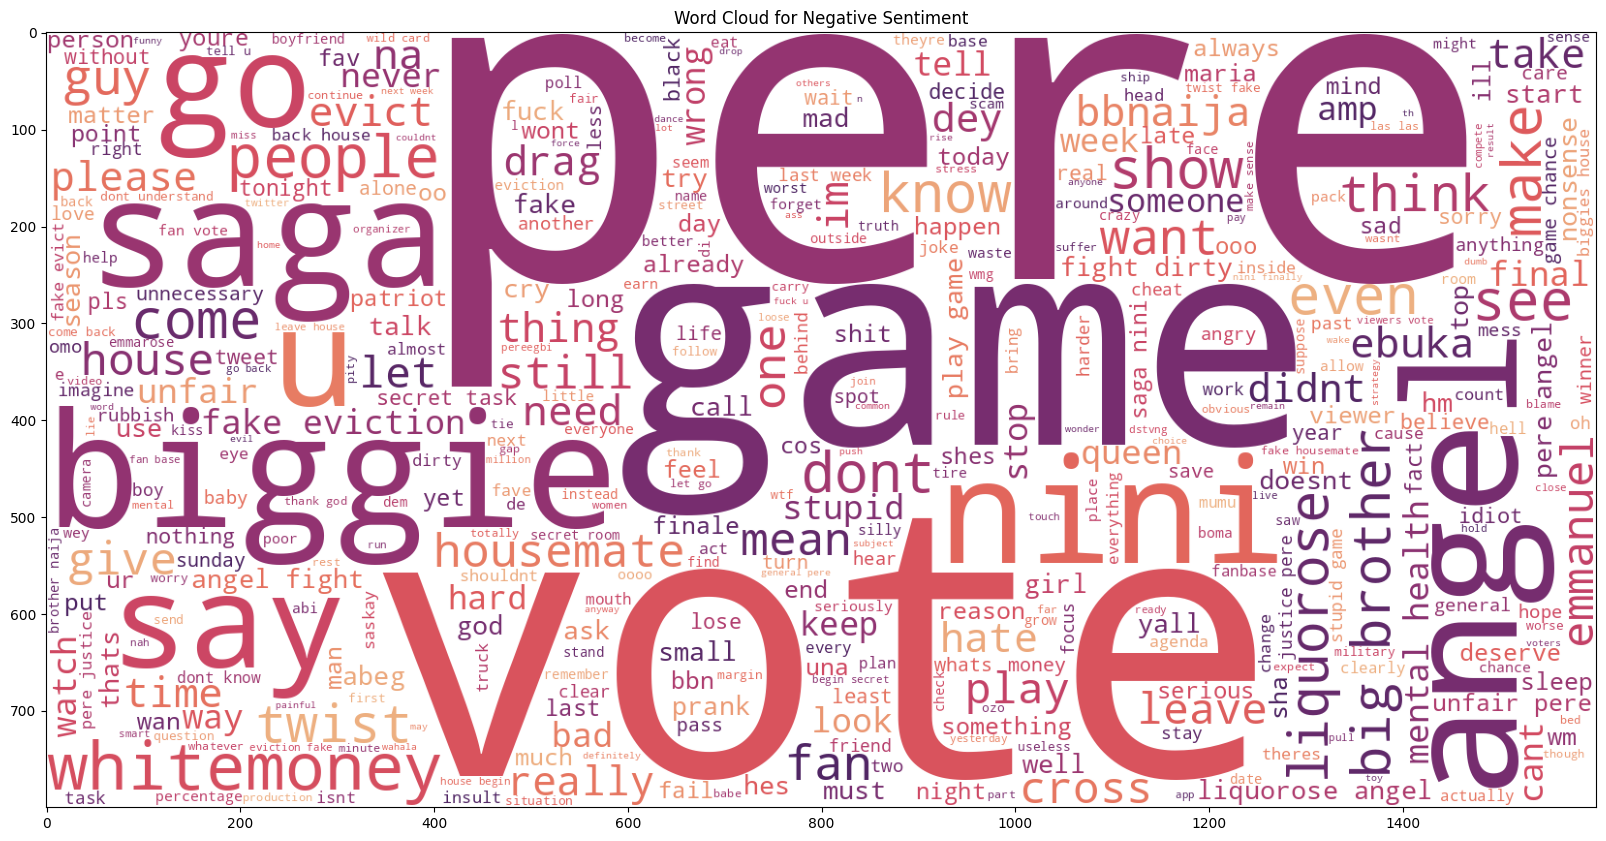

In [25]:
plt.figure(figsize=(20,20))
plt.title('Word Cloud for Negative Sentiment')
neg_wc = WordCloud(max_words=1000, min_font_size=10,
                height=800,width=1600,background_color="white",
                colormap='flare').generate(' '.join(neg_df['Cleaned Tweet']))

plt.imshow(neg_wc)

In [26]:
df['Sentiment'].value_counts()

Neutral     4736
Positive    3566
Negative    1698
Name: Sentiment, dtype: int64

In [27]:
def encSentiment(sentiment):
    '''
    Encode Sentiment
    '''
    if sentiment == 'Positive':
        return 1

    elif sentiment == 'Negative':
        return -1

    else:
        return 0

#Save data
data = pd.DataFrame()
data['cleaned_tweet'] = df['Cleaned Tweet']
data['sentiment'] = df['Sentiment'].apply(encSentiment)

data.to_csv('processed_data.csv', index=False)

In [28]:

new_df = pd.read_csv('processed_data.csv')
new_df.head()

,cleaned_tweet,sentiment
0,come pere angel ask leave house sunday live eviction show move white room pere,1
1,gonna lie big brother mess pere isnt fair even fan,1
2,production team doesnt care bite people mental health sad cant begin imagine whats go head right pere whos military angel already battle anxiety,-1
3,kayode one responsible show bore hms,1
4,video peres fan protest bbnaijas eviction twist lagos pere,0


In [29]:
train_x, test_x, train_y, test_y = train_test_split(new_df['cleaned_tweet'], new_df['sentiment'], test_size=0.2)

In [72]:
from sklearn.preprocessing import OneHotEncoder
train_y = OneHotEncoder().fit_transform(np.array(train_y).reshape(-1, 1))
test_y = OneHotEncoder().fit_transform(np.array(test_y).reshape(-1, 1))


In [91]:
train_y.toarray()

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]])

<h1><b><span style="color: #e56b6f; font-size: 28px">MODEL BUILDING</span></b></h1>


In [78]:
tokenizer = Tokenizer(num_words=50000, oov_token='<OOV>')
tokenizer.fit_on_texts(train_x.astype('str'))
total_word = len(tokenizer.word_index)
print('Total distinct words: {}'.format(total_word))

train_seq = tokenizer.texts_to_sequences(train_x.astype('str'))
train_padded = pad_sequences(train_seq, maxlen=50, padding='post')

test_seq = tokenizer.texts_to_sequences(test_x.astype('str'))
test_padded = pad_sequences(test_seq, maxlen=50, padding='post')

Total distinct words: 10376


In [79]:
train_padded.shape

(8000, 50)

In [80]:
pickle.dump(tokenizer, open('tokenizer.pkl', 'wb'))

In [92]:
def LSTM():
    # model = tf.keras.models.Sequential([
    #             tf.keras.layers.Embedding(total_word, 8),
    #             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    #             tf.keras.layers.Dropout(0.5),
    #             tf.keras.layers.Dense(8, kernel_regularizer=tf.keras.regularizers.l2(0.001),
    #                                   bias_regularizer=tf.keras.regularizers.l2(0.001),
    #                                   activation='relu'),
    #             tf.keras.layers.Dropout(0.5),
    #             tf.keras.layers.Dense(3, activation='softmax')
    #         ])
    from keras.constraints import max_norm


    model = tf.keras.models.Sequential([
                tf.keras.layers.Embedding(50000,128,input_length=train_padded.shape[1]),
                tf.keras.layers.Dropout(0.5),
                tf.keras.layers.LSTM(32,kernel_constraint=max_norm(3)),
                tf.keras.layers.Dense(32,activation='relu',kernel_regularizer=l2(0.01)),
                tf.keras.layers.Dropout(0.5),
                tf.keras.layers.Dense(3,activation='softmax')
            ])

    print(model.summary())

    model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(train_padded, train_y.toarray(), epochs=25, validation_data=(test_padded, test_y.toarray()))

    return model


In [93]:
model = LSTM()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 50, 128)           6400000   
                                                                 
 dropout_32 (Dropout)        (None, 50, 128)           0         
                                                                 
 lstm_14 (LSTM)              (None, 32)                20608     
                                                                 
 dense_36 (Dense)            (None, 32)                1056      
                                                                 
 dropout_33 (Dropout)        (None, 32)                0         
                                                                 
 dense_37 (Dense)            (None, 3)                 99        
                                                                 
Total params: 6421763 (24.50 MB)
Trainable params: 64

<Axes: >

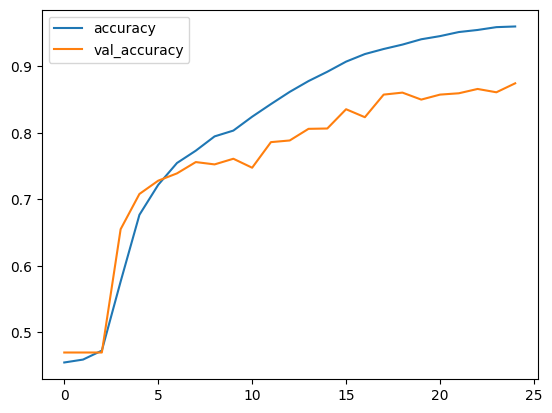

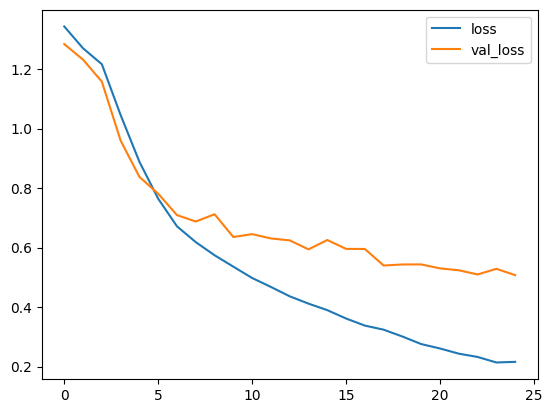

In [94]:
metrics = pd.DataFrame(model.history.history)
metrics[['accuracy', 'val_accuracy']].plot()
metrics[['loss', 'val_loss']].plot()

In [97]:
test_acc = model.evaluate(test_padded, test_y.toarray())
print("Testing Accuracy(%): ", test_acc[1]*100)



63/63 [==============================] - 0s 4ms/step - loss: 0.5074 - accuracy: 0.8745
Testing Accuracy(%):  87.44999766349792


In [99]:
y_pred = model.predict(test_padded)
y_predicted_labels = np.array([ np.argmax(i) for i in y_pred])
y_test_labels = np.array([ np.argmax(i) for i in test_y.toarray()])

63/63 [==============================] - 0s 3ms/step


In [111]:
test_y.toarray()

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [110]:
np.unique(y_predicted_labels)

array([0, 1, 2])

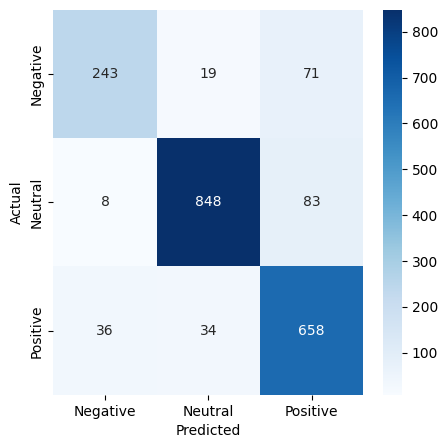

In [100]:
import seaborn as sn
cm = confusion_matrix(y_test_labels, y_predicted_labels)
labels=['Negative', 'Neutral','Positive']
plt.figure(figsize=(5,5))
sn.heatmap(cm,  xticklabels=labels, yticklabels=labels, fmt='d', annot=True, cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [98]:
model.save('sentiment_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<h1><b><span style="color: #e56b6f; font-size: 28px">PREDICTION</span></b></h1>


In [44]:
# Deep Neural Network
def dl_predict(text):
    clean_text = cleanTweet(text)
    seq = tokenizer.texts_to_sequences([str(clean_text)])
    padded = pad_sequences(seq, maxlen=50, padding='post')

    pred = model.predict(padded)
    # Get the label name back
    # result = lb.inverse_transform(pred)[0]

    return pred

In [102]:
text = 'Such a comfy place to stay with the loved one'

print('Prediction using DNN: {}'.format(dl_predict(text)))